$\#\#\#\#\#\#\#$ Libraries $\#\#\#\#\#\#\#$

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
from sklearn import metrics
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.pipeline import make_pipeline



import warnings

warnings.filterwarnings('ignore') 

$\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#$

# Data

In [2]:
df = pd.read_csv('DelayedFlights_Mod.csv')

In [3]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
df.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime',
       'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay', 'VelocityAir', 'DelayedArr', 'TotalDelayed',
       'TaxiTime'],
      dtype='object')

In [5]:
df2 = df[['ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Distance', 
          'TaxiIn', 'TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay', 'VelocityAir', 
          'DelayedArr', 'TotalDelayed']]

In [6]:
df2.head()

,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,LateAircraftDelay,VelocityAir,DelayedArr,TotalDelayed
0,128.0,150.0,116.0,-14.0,8.0,810,4.0,8.0,0.0,0.0,0.0,0.0,379.687500,0,0.0
1,128.0,145.0,113.0,2.0,19.0,810,5.0,10.0,0.0,0.0,0.0,0.0,379.687500,1,0.0
2,96.0,90.0,76.0,14.0,8.0,515,3.0,17.0,0.0,0.0,0.0,0.0,321.875000,1,0.0
3,90.0,90.0,77.0,34.0,34.0,515,3.0,10.0,2.0,0.0,0.0,32.0,343.333333,1,34.0
4,101.0,115.0,87.0,11.0,25.0,688,4.0,10.0,0.0,0.0,0.0,0.0,408.712871,1,0.0


In [7]:
# count the values on column DelayedArr:
df2.DelayedArr.value_counts() / len(df2)

1    0.907738
0    0.092262
Name: DelayedArr, dtype: float64

We see that our dataset has a $90.77\%$ of late aircrafts, and a $9.23\%$ of arrivals on time/earlier.

We want this percentages being reflected to our sample. To do so, we will use sample for each group:

In [8]:
dfpr = df2.sample(frac=0.5, random_state=42)

In [9]:
dfpr.DelayedArr.value_counts()/len(dfpr)

1    0.908062
0    0.091938
Name: DelayedArr, dtype: float64

We can see that the values change to the 3 value: 90.81 and 9.19, a difference of 0.04 for both, we can use this function to split the dataset into one similar as our.

In [10]:
dfpr.shape

(964184, 15)

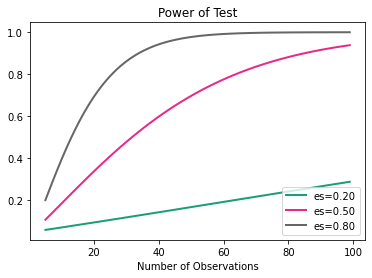

In [11]:
# https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/
from statsmodels.stats.power import TTestIndPower
# parameters for power analysis
effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.array(range(5, 100))
# calculate power curves from multiple power analyses
analysis = TTestIndPower()
analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)
plt.show()

We can see that if we are interested in a large effect that a point of diminishing returns in terms of statistical power occurs at around 40-to-50 observations. (Around the 40-50% of the total dataset).

============= Random things =============

In [12]:
100 * (50000 / (50000+3164+3175+521961))

8.646031471554556

In [13]:
100 * (3164 / (50000+3164+3175+521961))

0.5471208715199724

In [14]:
100 * (3175 / (50000+3164+3175+521961))

0.5490229984437143

In [15]:
100 * (521961 / (50000+3164+3175+521961))

90.25782465848175

In [16]:
100 * (45240 / (45240+8135+5362+519774))

7.82007602275497

In [17]:
100 * (8135 / (45240+8135+5362+519774))

1.40619625210238

In [18]:
100 * (5362 / (45240+8135+5362+519774))

0.9268622377102597

In [19]:
100 * (519774 / (45240+8135+5362+519774))

89.8468654874324

In [38]:
100 * (53375 / (53375 + 525136))

9.22627227485735

In [37]:
100 * (525136 / (53375 + 525136))

90.77372772514265

============= Time that takes to run knn with algorithm brute =============

In [20]:
# take only 500:
dfp = df2.sample(50000)
# to do this part, we first will take a subsample of the dataset df2p:
Xp = np.array(dfp.drop(['ArrDelay','DelayedArr'], axis=1))
yp = np.array(dfp['DelayedArr']).reshape(-1,1)

Xp_train, Xp_test, yp_train, yp_test = train_test_split(Xp, yp.ravel(), test_size=0.3, random_state=42, 
                                                    shuffle=True, stratify=yp)
Xp_train.shape

(35000, 13)

350
700
3500
7000
21000
35000
[0.3868408203125, 0.6079320907592773, 1.4200677871704102, 3.475005865097046, 28.65158462524414, 81.64045524597168]


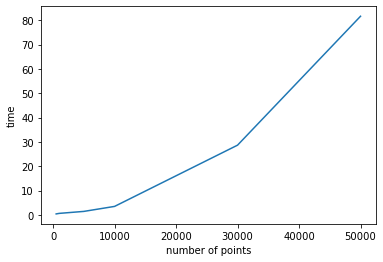

In [23]:
import time
n = [500, 1000, 5000, 10000, 30000, 50000]

timetot = []
for j in n:
    dfp = df2.sample(j)
    # to do this part, we first will take a subsample of the dataset df2p:
    Xp = np.array(dfp.drop(['ArrDelay','DelayedArr'], axis=1))
    yp = np.array(dfp['DelayedArr']).reshape(-1,1)

    Xp_train, Xp_test, yp_train, yp_test = train_test_split(Xp, yp.ravel(), test_size=0.3, random_state=42, 
                                                    shuffle=True, stratify=yp)
    print(Xp_train.shape[0])

    algo = {'brute'}#{'auto', 'ball_tree', 'kd_tree', 'brute'}

    MAEtrain_knn = []
    MAEpre_knn = []

    Strain_knn = []
    Stest_knn = []

    time0 = time.time()
    for i in algo:
        knn = KNeighborsClassifier(n_neighbors=5, algorithm=i,  n_jobs=-1)
        knn.fit(Xp_train, yp_train)
        
        yknn = knn.predict(Xp_train)
        MAEtrain_knn.append(metrics.mean_absolute_error(yp_train, yknn))
        Strain_knn.append(knn.score(Xp_train, yp_train))
        
        ypknn = knn.predict(Xp_test)
        MAEpre_knn.append(metrics.mean_absolute_error(yp_test, ypknn))
        Stest_knn.append(knn.score(Xp_test, yp_test))
    
        #print(i, MAEtrain_knn, MAEpre_knn)

    now = time.time()
    timetot.append(now - time0)
    
#print('MAE train: ', MAEtrain_knn)
#print('Score train: ', Strain_knn) 
#print('MAE test: ', MAEpre_knn)
#print('Score test: ', Stest_knn)
print(timetot)

plt.plot(n, timetot)
plt.xlabel('number of points')
plt.ylabel('time (seconds)')
plt.show()

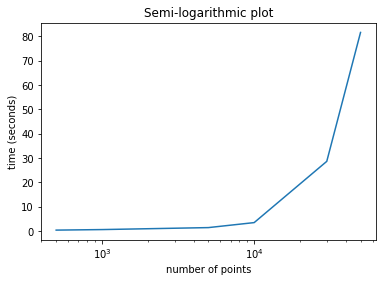

In [33]:
plt.plot(n, timetot)
plt.xscale('log')
plt.title('Semi-logarithmic plot')
plt.xlabel('number of points')
plt.ylabel('time (seconds)')
plt.show()

The graph show linear behaviour for low values, below 10000, and above it shows exponencial behaviour. But first, we will see how it will go if it were linear (lower values of n show linear behaviour). Then we predict time for exponencial fitting.

In [25]:
model = np.polyfit(n, timetot, 1)
model

array([ 1.57816680e-03, -6.01853493e+00])

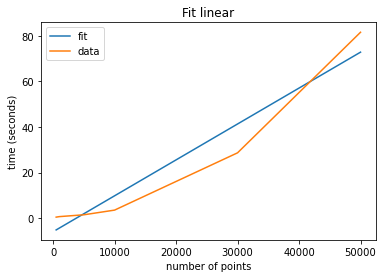

In [35]:
x_fitted = np.linspace(np.min(n), np.max(n),10)
y_fitted = model[0]*x_fitted + model[1]
line1 = plt.plot(x_fitted, y_fitted)
line2 = plt.plot(n, timetot)
plt.legend(['fit', 'data'])
plt.title('Fit linear')
plt.xlabel('number of points')
plt.ylabel('time (seconds)')
plt.show()

In [27]:
pred = np.poly1d(model)
num = 539942
pred(num)

846.1000024017908

In [28]:
p = np.polyfit(n, np.log(timetot),1)

In [29]:
p

array([ 1.04775243e-04, -3.67401762e-01])

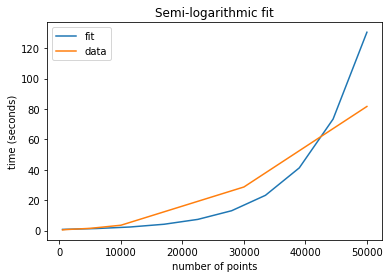

In [36]:
x_fitted = np.linspace(np.min(n), np.max(n), 10)
y_fitted = np.exp(p[1]) * np.exp(p[0]*x_fitted)
line1 = plt.plot(x_fitted, y_fitted)
line2 = plt.plot(n, timetot)
plt.legend(['fit', 'data'])
plt.title('Semi-logarithmic fit')
plt.xlabel('number of points')
plt.ylabel('time (seconds)')
plt.show()

In [31]:
predict = np.poly1d(p)
num = 539942
predict(num)

56.2051523866927

In [32]:
np.exp(predict(num))

2.567955751193492e+24

In [12]:
import time
n = [500, 1000, 5000, 10000, 30000, 50000, 100000, 500000]

timetot = []
for j in n:
    dfp = df2.sample(j)
    # to do this part, we first will take a subsample of the dataset df2p:
    Xp = np.array(dfp.drop(['ArrDelay','DelayedArr'], axis=1))
    yp = np.array(dfp['DelayedArr']).reshape(-1,1)

    Xp_train, Xp_test, yp_train, yp_test = train_test_split(Xp, yp.ravel(), test_size=0.3, random_state=42, 
                                                    shuffle=True, stratify=yp)
    print(Xp_train.shape[0])

    algo = {'rbf'}

    MAEtrain_svc = []
    MAEpre_svc = []

    Strain_svc = []
    Stest_svc = []

    time0 = time.time()
    for i in algo:
        mSVC = svm.SVC(kernel=i,random_state=42, verbose=True)
        mSVC.fit(Xp_train, yp_train)
        
        ysvc = mSVC.predict(Xp_train)
        MAEtrain_svc.append(metrics.mean_absolute_error(yp_train, ysvc))
        Strain_svc.append(mSVC.score(Xp_train, yp_train))
        
        ypsvc = mSVC.predict(Xp_test)
        MAEpre_svc.append(metrics.mean_absolute_error(yp_test, ypsvc))
        Stest_svc.append(mSVC.score(Xp_test, yp_test))
    
        #print(i, MAEtrain_knn, MAEpre_knn)

    now = time.time()
    timetot.append(now - time0)



350
[LibSVM]*..
*
optimization finished, #iter = 711
obj = -61.571670, rho = 0.814312
nSV = 74, nBSV = 53
Total nSV = 74
700
[LibSVM]*
optimization finished, #iter = 586
obj = -137.751663, rho = 0.985900
nSV = 152, nBSV = 131
Total nSV = 152
3500
[LibSVM]*.
*
optimization finished, #iter = 1050
obj = -629.025857, rho = 1.000262
nSV = 645, nBSV = 619
Total nSV = 645
7000
[LibSVM].
*
optimization finished, #iter = 1719
obj = -1306.474806, rho = 0.982346
nSV = 1333, nBSV = 1310
Total nSV = 1333
21000
[LibSVM]...
*
optimization finished, #iter = 3408
obj = -3831.082580, rho = 0.904496
nSV = 3970, nBSV = 3939
Total nSV = 3970
35000
[LibSVM]....
*.
*
optimization finished, #iter = 5463
obj = -6099.385737, rho = 0.943308
nSV = 6444, nBSV = 6419
Total nSV = 6444
70000
[LibSVM]........
*.
*
optimization finished, #iter = 9676
obj = -11750.422189, rho = 0.795587
nSV = 13060, nBSV = 13033
Total nSV = 13060
350000
[LibSVM].................................
*..
*.
*
optimization finished, #iter = 35

[0.008987665176391602, 0.02699112892150879, 0.4932985305786133, 2.065704345703125, 18.428059577941895, 49.921814918518066, 213.07927775382996, 5155.6162123680115]


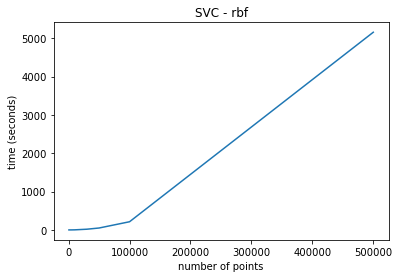

In [13]:
print(timetot)
plt.plot(n, timetot)
plt.xlabel('number of points')
plt.ylabel('time (seconds)')
plt.title('SVC - rbf')
plt.show()

The time seems to grow linearly for datasets below 100000 entries, while exponencial for datasets over it.

In [15]:
model = np.polyfit(n, timetot, 1)
predict = np.poly1d(model)
num = df2.shape[0]
predict(num)

19998.085919248166

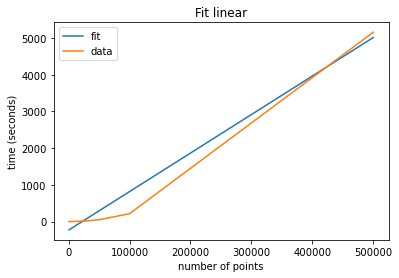

In [16]:
x_fitted = np.linspace(np.min(n), np.max(n),10)
y_fitted = model[0]*x_fitted + model[1]
line1 = plt.plot(x_fitted, y_fitted)
line2 = plt.plot(n, timetot)
plt.legend(['fit', 'data'])
plt.title('Fit linear')
plt.xlabel('number of points')
plt.ylabel('time (seconds)')
plt.show()

In [17]:
predict(67492+28926)

778.1086486547018

====== More random things ======= 

In [18]:
100* ( 47292/ (47292+5958+13662+511599))

8.174779736253935

In [19]:
100* ( 5958/ (47292+5958+13662+511599))

1.0298853435803295

In [20]:
100* ( 13662/ (47292+5958+13662+511599))

2.361579987243112

In [21]:
100* ( 511599/ (47292+5958+13662+511599))

88.43375493292262

In [25]:
100* ( 28729/ (28729+24521+25847+500000))

4.960999625278666

In [26]:
100* ( 24521/ (28729+24521+25847+500000))

4.234351067265069

In [27]:
100* ( 25847/ (28729+24521+25847+500000))

4.463328250707567

In [28]:
100* ( 500000/ (28729+24521+25847+500000))

86.3413210567487

In [29]:
100* ( 25774/ (25774+27476+19454+505807))

4.455230756199969

In [30]:
100* ( 27476/ (25774+27476+19454+505807))

4.749434323634295

In [31]:
100* ( 19454/ (25774+27476+19454+505807))

3.362770975832784

In [32]:
100* ( 505807/ (25774+27476+19454+505807))

87.43256394433295

In [33]:
100* ( 24702/ (24702+28548+11753+513508))

4.2699274516819905

In [34]:
100* ( 28548/ (24702+28548+11753+513508))

4.9347376281522735

In [35]:
100* ( 11753/ (24702+28548+11753+513508))

2.031594904850556

In [36]:
100* ( 513508/ (24702+28548+11753+513508))

88.76374001531518